# Mitigating sampling problems in IONQ

A modification of the test by sampling using Bernstein Vaziriani circuits of multiple lengths described in https://qiskit.org/ecosystem/mthree/sampling.html

In [1]:
import numpy as np
from qiskit import *
from qiskit.visualization import plot_histogram
import mthree
from time import time
from qiskit_ionq import *

In [2]:
# Setup experiment
token = 'YOUR-TOKEN-HERE'
provider = IonQProvider(token)

backend = provider.get_backend("ionq_simulator")

def bv_ones_circs(N):
    qc = QuantumCircuit(N, N-1)
    qc.x(N-1)
    qc.h(range(N))
    qc.cx(range(N-1), N-1)
    qc.h(range(N-1))
    qc.barrier()
    qc.measure(range(N-1), range(N-1))
    return qc


def most_likely_bitstring(dist):
    sorted_dist = dict(sorted(dist.items(), key=lambda item: item[1], reverse=True))
    key = next(iter(sorted_dist.keys()))
    val = next(iter(sorted_dist.values()))
    return key, val

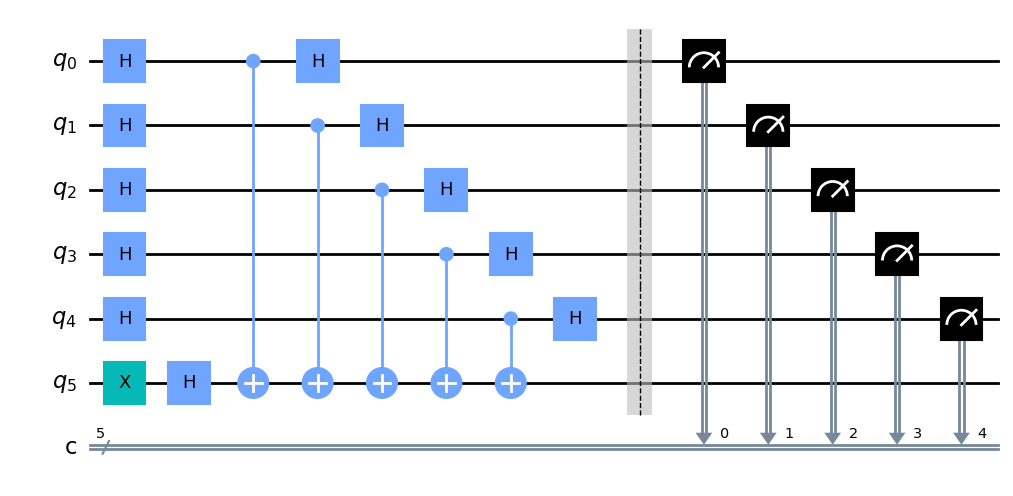

In [3]:
# Perform experiment

# Qubit range
bit_range = range(3, 8)

circs = [bv_ones_circs(N+1) for N in bit_range]
#trans_circs = transpile(circs, backend, optimization_level=3)

shots = 8192
counts = []
for qc in circs:
    count = backend.run(qc, shots=shots).result().get_counts()
    counts.append(count)

display(circs[len(circs) - 3].draw())
#print (counts)

In [4]:
# Process Raw results (no mitigation)
raw_success_probs = []

for idx, num_bits in enumerate(bit_range):
    max_bitstring, max_value = most_likely_bitstring(counts[idx])
    if max_bitstring != '1'*num_bits:
        raise Exception('Returned wrong bit-string')
    raw_success_probs.append(max_value/shots)

print (raw_success_probs)

[0.94677734375, 0.9359130859375, 0.9097900390625, 0.905517578125, 0.8883056640625]


In [5]:
# filter mitigatiom with various ranges
import mitigation as mitigation

# low mitigation (type image)
in_range0 = 'image'
quasis0 = mitigation.get_probabilities(counts, shots, in_range = in_range0)
mit0_success_probs = []

for idx, num_bits in enumerate(bit_range):
    max_bitstring, max_value = most_likely_bitstring(quasis0[idx])
    if max_bitstring != '1'*num_bits:
        raise Exception('Returned wrong bit-string')
    mit0_success_probs.append(max_value)

# 1% mitigation
in_range1 = (0.01, 0.99)

start       = time()
quasis1 = mitigation.get_probabilities(counts, shots, in_range = in_range1)
end       = time()

print(f'Filter @ 1% mitigation execution time (ms): {(end - start)*1000:.2f}')

mit1_success_probs = []

for idx, num_bits in enumerate(bit_range):
    max_bitstring, max_value = most_likely_bitstring(quasis1[idx])
    if max_bitstring != '1'*num_bits:
        raise Exception('Returned wrong bit-string')
    mit1_success_probs.append(max_value)

# 2% mitigation
in_range2 = (0.02, 0.98)
quasis2 = mitigation.get_probabilities(counts, shots, in_range = in_range2)
mit2_success_probs = []

for idx, num_bits in enumerate(bit_range):
    max_bitstring, max_value = most_likely_bitstring(quasis2[idx])
    if max_bitstring != '1'*num_bits:
        raise Exception('Returned wrong bit-string')
    mit2_success_probs.append(max_value)

print (str(in_range0) + ' = ' + str(mit0_success_probs))
print (str(in_range1) + ' = ' + str(mit1_success_probs))
print (str(in_range2) + ' = ' + str(mit2_success_probs))

Filter @ 1% mitigation execution time (ms): 0.00
image = [0.9475806451612904, 0.9373930056248472, 0.9121175030599755, 0.9089460784313724, 0.8927607361963191]
(0.01, 0.99) = [0.9841945694161585, 0.984768383880349, 0.9749486805070577, 0.9822721624748276, 0.9793701610532162]
(0.02, 0.98) = [1.0, 1.0, 1.0, 1.0, 1.0]


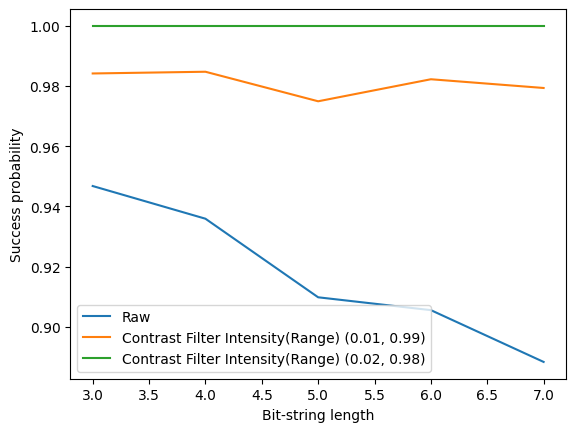

In [6]:
# Plot results
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(bit_range, raw_success_probs, label='Raw')
#ax.plot(bit_range, mit0_success_probs, label='Contrast Filter Intensity(Range) ' + str(in_range0))
ax.plot(bit_range, mit1_success_probs, label='Contrast Filter Intensity(Range) ' + str(in_range1))
ax.plot(bit_range, mit2_success_probs, label='Contrast Filter Intensity(Range) ' + str(in_range2))

ax.set_ylabel('Success probability')
ax.set_xlabel('Bit-string length')
ax.legend();